In [1]:
import torch
import wandb
import os

from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean
from inference.bayesian.models import TorchModel, BayesianModel#, HorseshoeSSVS
# from inference.bayesian.utils import plot_forecast
from inference.inference import inference
from ESN.utils import run_esn

import pyro

In [2]:
config = {
            "dataset": "acea",
            "model_widths": [50, 10, 1],
            "activation": "tanh",
            "distributions": ["gauss", "unif", "gauss"],
            "parameters": [[0,1],[0,10]],
            "dim_reduction": False,
            "inference": "svi",
            "lr": 0.03,
            "num_iterations": 200,
            "quantile": 0.95,
            "plot": False
            }

os.environ["WANDB_MODE"]="offline"
wandb.init(project="bayes_rc", config=config)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
Ytr, train_embedding, val_embedding, Yte, test_embedding = run_esn(config.dataset, device, dim_reduction=config.dim_reduction)

Tr: 4882, Val: 1047, Te: 1047


# SVI

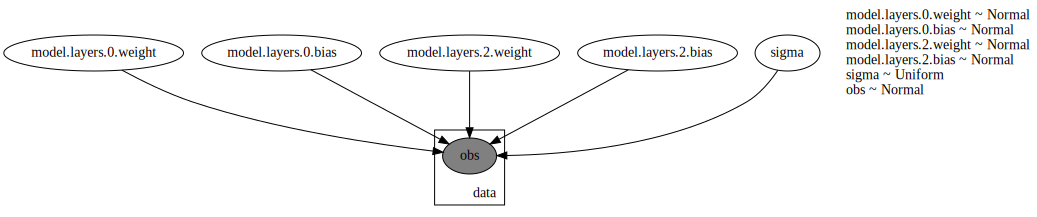

In [5]:
torch_model = TorchModel(config.model_widths, config.activation).to(device)
svi_model = BayesianModel(torch_model, config, device)
svi_model.render_model(model_args=(train_embedding[0], Ytr[0]))

Autoguide for testing

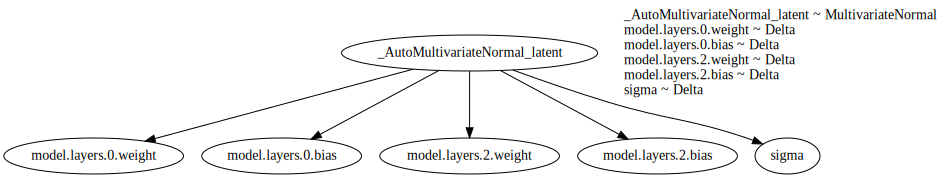

In [6]:
# To enforce all the parameters in the guide on the GPU, since we use an autoguide
if device != 'cpu':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

guide = AutoMultivariateNormal(svi_model, init_loc_fn=init_to_mean)
pyro.render_model(guide, model_args=(train_embedding, Ytr), render_distributions=True)

Il problema dello scrivere una guida custom è fare in modo che le variabili latenti siano correlate. Un approccio è quello usato dall'autoguide: usare gaussiane univariate e poi correlarle con la decomposizione di Cholesky (guarda [qui](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4066115)).

Se io voglio usare distribuzioni diverse dalla gaussiana, come adattare questo approccio? Si possono mescolare distribuzioni diverse?

Una possibilità è di usare le gaussiane inizialmente, ma poi quando si va a fare il sampling le si trasforma in distribuzioni diverse (guarda [qui](https://stats.stackexchange.com/a/415553), ma si può fare? Una volta che le correlo posso trasformarle? C'è un altro metodo per altre distribuzioni?)

Ma mi serve davvero tutto questo controllo?

In [7]:
num_samples = 2000

predictive, diagnostics = inference(config, svi_model, guide, X_train=train_embedding, Y_train=Ytr, X_test=test_embedding, Y_test=Yte, num_samples=num_samples)

ValueError: at site "obs", invalid log_prob shape
  Expected [4882], actual [4882, 4882]
  Try one of the following fixes:
  - enclose the batched tensor in a with pyro.plate(...): context
  - .to_event(...) the distribution being sampled
  - .permute() data dimensions